# Session 3 — Sentence-Level Analysis
## Measure 3: Sentence Embeddings (LLMs as Semantic Encoders)

### What are Sentence Embeddings?
Sentence embeddings are **dense vector representations** of sentences that capture their semantic meaning in a high-dimensional space. Unlike traditional word-based approaches, sentence embeddings encode the entire meaning of a sentence into a single fixed-length vector (typically 384-768 dimensions).

### How They Work
Modern sentence embedding models (like SBERT - Sentence-BERT) use **transformer architectures** pre-trained on massive text corpora. These models:
- Convert sentences into numerical vectors where semantically similar sentences are close together in vector space
- Capture context, syntax, and semantic relationships
- Enable comparison of sentences based on meaning rather than just word overlap

### Key Applications in NLP
1. **Semantic Similarity**: Measure how similar two sentences are in meaning
2. **Information Retrieval**: Find relevant documents or passages based on semantic search
3. **Text Clustering**: Group similar sentences or documents together
4. **Duplicate Detection**: Identify paraphrases or semantically identical content
5. **Question Answering**: Match questions with relevant answers
6. **Content Recommendation**: Suggest similar content based on semantic understanding

### Why Use Sentence Embeddings?
- **Beyond Keywords**: Captures meaning even when different words are used
- **Efficient**: Pre-computed embeddings allow fast similarity comparisons
- **Robust**: Works across different phrasings and writing styles
- **Multilingual**: Many models support cross-lingual semantic search

### This Demonstration
We'll use the **all-MiniLM-L6-v2** model to:
- Encode example sentences into semantic vectors
- Visualize their relationships in 2D space using PCA
- Compute similarity scores between sentence pairs

In [32]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Load pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Example sentences with varying semantic relationships
sentences = [
    "Alice looked at the cat.", 
    "The cat stared back at Alice.",  # Similar to first
    "Bob opened the door.",
    "The door was opened by Bob.",    # Similar to third
    "The weather is beautiful today.",
    "It's a sunny and pleasant day.", # Similar to fifth
    "Programming is challenging.",
    "The ocean is vast and deep."     # Unrelated
]

# Generate embeddings
embeddings = model.encode(sentences)

print(f"Embedding shape: {embeddings.shape}")
print(f"Each sentence is represented as a {embeddings.shape[1]}-dimensional vector\n")

Embedding shape: (8, 384)
Each sentence is represented as a 384-dimensional vector



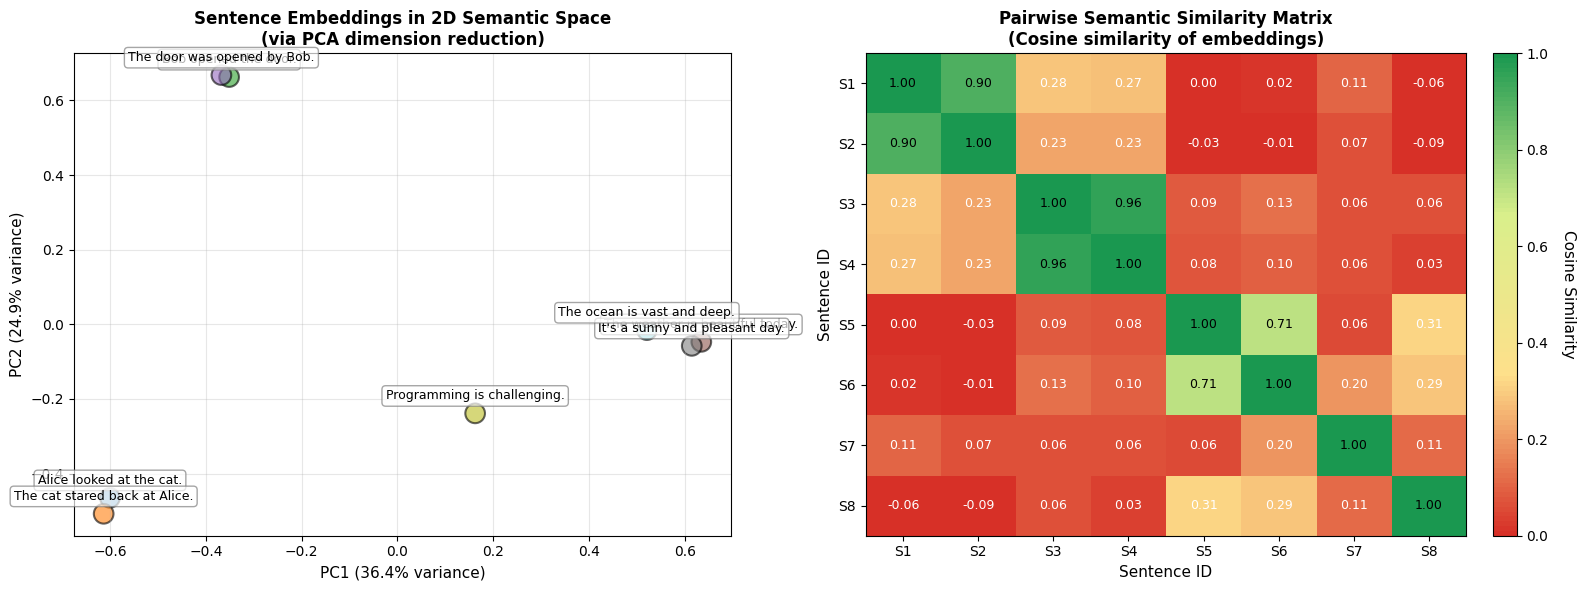


SENTENCE REFERENCE:
S1: Alice looked at the cat.
S2: The cat stared back at Alice.
S3: Bob opened the door.
S4: The door was opened by Bob.
S5: The weather is beautiful today.
S6: It's a sunny and pleasant day.
S7: Programming is challenging.
S8: The ocean is vast and deep.


In [33]:
# Create a more comprehensive visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: 2D PCA Visualization ---
pca = PCA(n_components=2)
points = pca.fit_transform(embeddings)

ax1 = axes[0]
scatter = ax1.scatter(points[:, 0], points[:, 1], c=range(len(sentences)), 
                      cmap='tab10', s=200, alpha=0.6, edgecolors='black', linewidth=1.5)

# Add labels with better positioning
for i, (s, (x, y)) in enumerate(zip(sentences, points)):
    # Truncate long sentences for readability
    label = s if len(s) < 35 else s[:32] + "..."
    ax1.annotate(label, (x, y), fontsize=9, ha='center', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'),
                xytext=(0, 10), textcoords='offset points')

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_title("Sentence Embeddings in 2D Semantic Space\n(via PCA dimension reduction)", 
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# --- Plot 2: Similarity Heatmap ---
from matplotlib.colors import LinearSegmentedColormap

# Compute cosine similarity matrix
similarity_matrix = util.cos_sim(embeddings, embeddings).numpy()

ax2 = axes[1]
# Create custom colormap
colors = ['#d73027', '#fee08b', '#d9ef8b', '#1a9850']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('similarity', colors, N=n_bins)

im = ax2.imshow(similarity_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Cosine Similarity', rotation=270, labelpad=20, fontsize=11)

# Set ticks and labels
ax2.set_xticks(range(len(sentences)))
ax2.set_yticks(range(len(sentences)))
short_labels = [f"S{i+1}" for i in range(len(sentences))]
ax2.set_xticklabels(short_labels, fontsize=10)
ax2.set_yticklabels(short_labels, fontsize=10)

# Add similarity scores as text
for i in range(len(sentences)):
    for j in range(len(sentences)):
        text_color = 'white' if similarity_matrix[i, j] < 0.5 else 'black'
        ax2.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                ha="center", va="center", color=text_color, fontsize=9)

ax2.set_title("Pairwise Semantic Similarity Matrix\n(Cosine similarity of embeddings)", 
              fontsize=12, fontweight='bold')
ax2.set_xlabel("Sentence ID", fontsize=11)
ax2.set_ylabel("Sentence ID", fontsize=11)

plt.tight_layout()
plt.show()

# Print the sentences for reference
print("\n" + "="*80)
print("SENTENCE REFERENCE:")
print("="*80)
for i, sent in enumerate(sentences):
    print(f"S{i+1}: {sent}")
print("="*80)

### Interpreting the Results

**Left Plot - 2D Semantic Space:**
- Sentences with similar meanings cluster together in the vector space
- Distance between points indicates semantic dissimilarity
- PCA reduces the 384-dimensional embeddings to 2D for visualization
- Note: Some information is lost in dimension reduction (see variance percentages)

**Right Plot - Similarity Matrix:**
- Values range from 0 (completely dissimilar) to 1 (identical)
- Diagonal values are always 1.0 (sentence compared to itself)
- Higher values (green) indicate semantically similar sentences
- Lower values (red) indicate semantically different sentences

**Key Observations:**
- Paraphrases (e.g., "Alice looked at the cat" vs "The cat stared back at Alice") show high similarity
- Semantically related sentences cluster together in both visualizations
- Unrelated sentences have low similarity scores despite being grammatically correct

In [ ]:
# Example: Finding most similar sentence pairs
print("\nTOP 5 MOST SIMILAR SENTENCE PAIRS:")
print("="*80)

# Get upper triangle indices (avoid duplicates and self-comparisons)
pairs = []
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        pairs.append((i, j, similarity_matrix[i, j]))

# Sort by similarity score
pairs.sort(key=lambda x: x[2], reverse=True)

# Display top 5
for rank, (i, j, score) in enumerate(pairs[:5], 1):
    print(f"{rank}. Similarity: {score:.4f}")
    print(f"   S{i+1}: {sentences[i]}")
    print(f"   S{j+1}: {sentences[j]}")
    print()

Loading sentence transformer model...
Generating embeddings...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


Embedding shape: (50, 384)
Each sentence → 384-dimensional vector
